In [152]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fftpack import fft
from scipy.fftpack import ifft

In [161]:
cutoff = 40
name = 'excel/test.xlsx'
save = False

In [162]:
def td2fd(xs):
    # input: N (even) real numbers
    # output: 1 + N // 2 complex numbers (the imaginary part of last number is zero)
    # or
    # input: N (odd) real numbers
    # output: 1 + N // 2 complex numbers (the imaginary part of last number is not zero)
    # complexity: O(n·logn)

    # wrapper
    original_dimension = len(xs.shape)
    if original_dimension < 2:
        xs = xs[np.newaxis, :]

    zs = fft(xs, axis=-1) * (2 / xs.shape[-1])
    zs[:, 0] /= 2
    if xs.shape[-1] % 2 == 0:
        zs[:, xs.shape[-1] // 2] /= 2

    # recover
    if original_dimension == 1:
        return zs[0, :xs.shape[-1] // 2 + 1]

    return zs[:, :xs.shape[-1] // 2 + 1]


def fd2td(zs, is_even=True):
    # input: 1 + N complex numbers (the imaginary part of last number is zero)
    # output: N * 2 (even) real numbers
    # or
    # input: 1 + N complex numbers (the imaginary part of last number is not zero)
    # output: 1 + N * 2 (odd) real numbers
    # complexity: O(n·logn)

    # wrapper
    original_dimension = len(zs.shape)
    if original_dimension < 2:
        zs = zs[np.newaxis, :]

    if is_even:
        zs = np.hstack((zs, np.flip(zs[:, 1:-1].conj(), axis=-1)))  # (N + 1) + (N - 1) = 2N
        zs *= zs.shape[1] / 2
        zs[:, 0] *= 2
        zs[:, zs.shape[1] // 2] *= 2
        xs = ifft(zs, axis=-1).real
    else:
        zs = np.hstack((zs, np.flip(zs[:, 1:].conj(), axis=-1)))  # (N + 1) + N = 2N + 1
        zs *= zs.shape[1] / 2
        zs[:, 0] *= 2
        xs = ifft(zs, axis=-1).real

    return xs[0] if original_dimension == 1 else xs

In [163]:
files = 'excel/IES_E9H12G7-v1.xlsx'
excel = pd.read_excel(files, sheet_name=None)

eload_fd = {}
hload_fd = {}
gload_fd = {}
wind = {}
time = np.concatenate([np.arange(-cutoff+1, 0), np.arange(1, cutoff)])
eload_fd['time'] = time
hload_fd['time'] = time
gload_fd['time'] = time
wind['time'] = time

for i, bus in enumerate(excel['wind'].keys()[1:]):
    temp = td2fd(excel['wind'][bus])[:cutoff]
    wind[bus] = fd2td(temp)

for i, bus in enumerate(excel['eLoad'].keys()[1:]):
    temp = td2fd(excel['eLoad'][bus])[:cutoff]
    eload_fd[bus] = fd2td(temp)

for i, pipe in enumerate(excel['hLoad'].keys()[1:]):
    temp = td2fd(excel['hLoad'][pipe])[:cutoff]
    hload_fd[pipe] = fd2td(temp)

for i, node in enumerate(excel['gLoad'].keys()[1:]):
    temp = td2fd(excel['gLoad'][node])[:cutoff]
    gload_fd[node] = fd2td(temp)

for i in ['wind', 'eLoad', 'hLoad', 'gLoad']:
    del excel[i]


excel['wind'] = pd.DataFrame(wind)
excel['eLoad'] = pd.DataFrame(eload_fd)
excel['hLoad'] = pd.DataFrame(hload_fd)
excel['gLoad'] = pd.DataFrame(gload_fd)

if save:
    with pd.ExcelWriter(name) as writer:
        for sheet_name in excel.keys():
            excel[sheet_name].to_excel(writer, sheet_name=sheet_name, index=False)


/var/folders/0y/7pbqzqwx41sbvsy1s77pqh_00000gn/T/ipykernel_35267/3212658590.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xs = xs[np.newaxis, :]


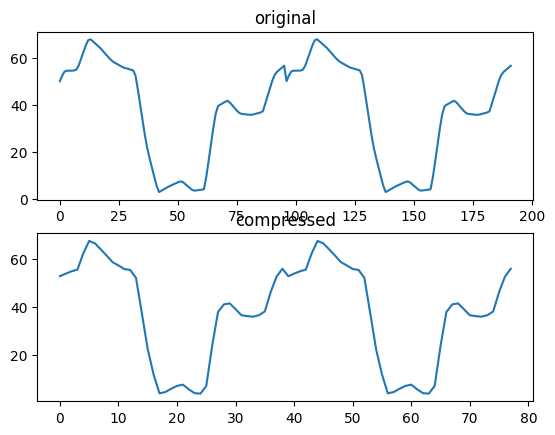

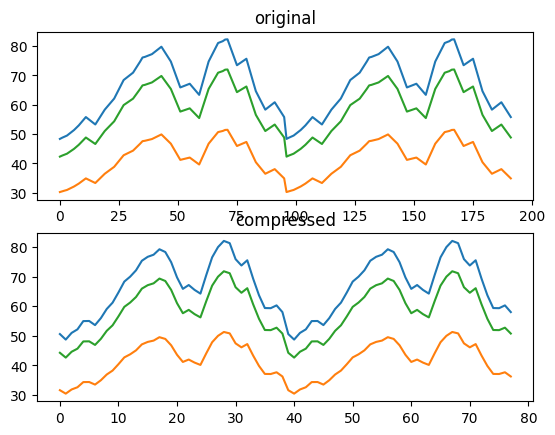

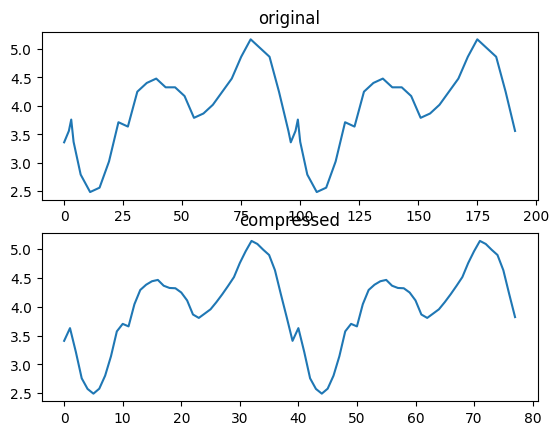

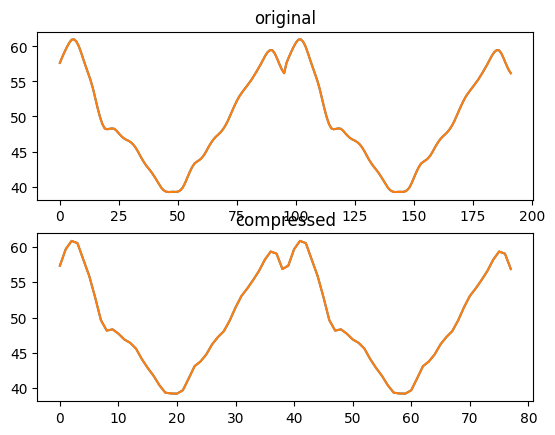

In [164]:
files = 'excel/IES_E9H12G7-v1.xlsx'
excel = pd.read_excel(files, sheet_name=None)


axs = plt.subplot(2, 1, 1)
axs.set_title('original')
axs.plot(excel['wind']['bus3(MW)'])
axs = plt.subplot(2, 1, 2)
axs.set_title('compressed')
axs.plot(wind['bus3(MW)'])
plt.show()

axs = plt.subplot(2, 1, 1)
axs.set_title('original')
for i, item in enumerate(excel['eLoad'].keys()[1:]):
    axs.plot(excel['eLoad'][item], label=item)
axs = plt.subplot(2, 1, 2)
axs.set_title('compressed')
for i, item in enumerate(excel['eLoad'].keys()[1:]):
    axs.plot(eload_fd[item])
plt.show()

axs = plt.subplot(2, 1, 1)
axs.set_title('original')
for i, item in enumerate(excel['gLoad'].keys()[1:]):
    axs.plot(excel['gLoad'][item], label=item)
axs = plt.subplot(2, 1, 2)
axs.set_title('compressed')
for i, item in enumerate(excel['gLoad'].keys()[1:]):
    axs.plot(gload_fd[item])
plt.show()

axs = plt.subplot(2, 1, 1)
axs.set_title('original')
for i, item in enumerate(excel['hLoad'].keys()[1:]):
    axs.plot(excel['hLoad'][item], label=item)
axs = plt.subplot(2, 1, 2)
axs.set_title('compressed')
for i, item in enumerate(excel['hLoad'].keys()[1:]):
    axs.plot(hload_fd[item])
plt.show()